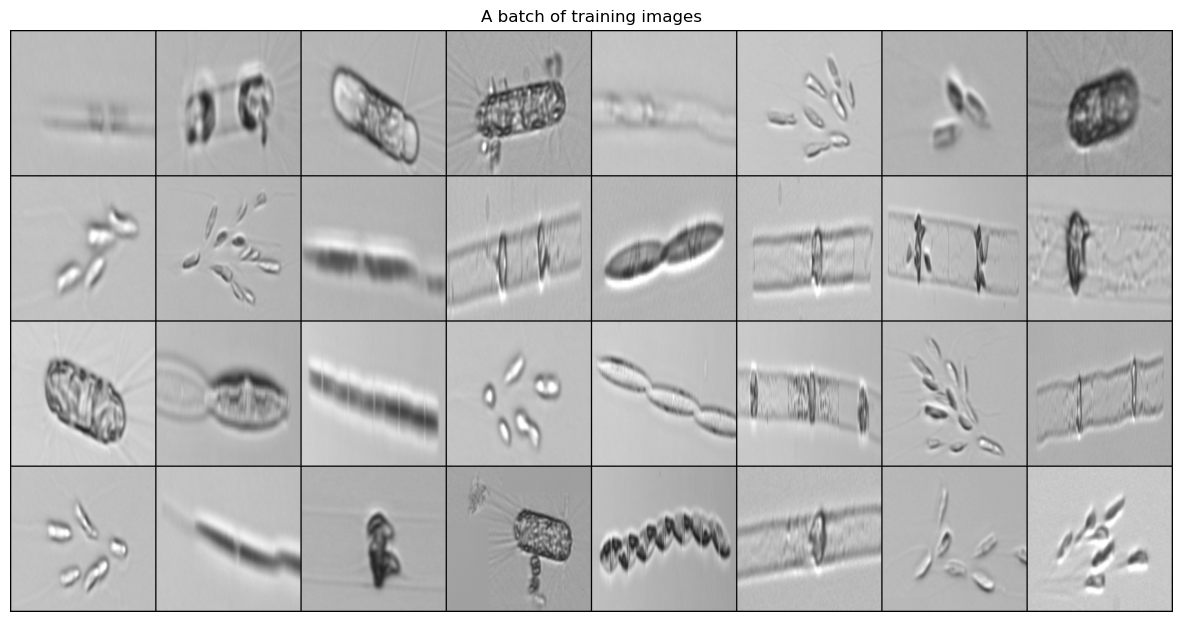

Labels:
['Pseudonitzschia', 'Corethron', 'Corethron', 'Corethron', 'Pseudonitzschia', 'Dinobryon', 'Dinobryon', 'Corethron', 'Dinobryon', 'Dinobryon', 'Pseudonitzschia', 'Dactyliosolen', 'Pseudonitzschia', 'Dactyliosolen', 'Dactyliosolen', 'Dactyliosolen', 'Corethron', 'Pseudonitzschia', 'Pseudonitzschia', 'Dinobryon', 'Pseudonitzschia', 'Dactyliosolen', 'Dinobryon', 'Dactyliosolen', 'Dinobryon', 'Pseudonitzschia', 'Dactyliosolen', 'Corethron', 'Pseudonitzschia', 'Dactyliosolen', 'Dinobryon', 'Dinobryon']


In [1]:
import os
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

image_size = 224
batch_size = 32
data_dir = "data"

all_data = datasets.ImageFolder(data_dir)
class_names = all_data.classes

indices = list(range(len(all_data)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=[all_data.imgs[i][1] for i in indices], random_state=42)

from torch.utils.data import Subset

train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

all_data.transform = train_transforms
train_dataset = Subset(all_data, train_idx)
all_data.transform = val_transforms
val_dataset = Subset(all_data, val_idx)

# Loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Batch visualize
images, labels = next(iter(train_loader))

def show_images(images, labels, class_names):
    # If normalized with mean=0.5, std=0.5 → undo it
    unnorm_images = images * 0.5 + 0.5  # unnormalize to [0,1]
    img_grid = utils.make_grid(unnorm_images, nrow=8)
    
    plt.figure(figsize=(15, 8))
    plt.imshow(img_grid.permute(1, 2, 0))  # Convert from [C, H, W] to [H, W, C]
    plt.title("A batch of training images")
    plt.axis('off')
    plt.show()

    # Optional: Print labels
    print("Labels:")
    print([class_names[i] for i in labels])

show_images(images, labels, class_names)

# Modelings

# SUPERVISED

In [2]:
import torch
import torch.nn as nn
from torchvision import models

def get_model(name, num_classes):
    if name == "resnet18":
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "vgg16":
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif name == "mobilenet_v2":
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        raise ValueError("Unsupported model")
    return model

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, correct = 0.0, 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
    return running_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct = 0.0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
    return running_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(class_names)
models_to_try = ["resnet18", "vgg16", "mobilenet_v2"]

for model_name in models_to_try:
    print(f"Training {model_name}...")
    model = get_model(model_name, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(5):  # or more
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        print(f"{model_name} | Epoch {epoch+1} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Training resnet18...


c:\Users\daapr\miniconda3\envs\it_fundamental\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\daapr\miniconda3\envs\it_fundamental\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\daapr/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


resnet18 | Epoch 1 | Train Acc: 0.9522 | Val Acc: 0.9977
resnet18 | Epoch 2 | Train Acc: 0.9988 | Val Acc: 0.9977
resnet18 | Epoch 3 | Train Acc: 0.9994 | Val Acc: 0.9977
resnet18 | Epoch 4 | Train Acc: 1.0000 | Val Acc: 1.0000
resnet18 | Epoch 5 | Train Acc: 1.0000 | Val Acc: 0.9977
Training vgg16...


c:\Users\daapr\miniconda3\envs\it_fundamental\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\daapr/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100.0%


vgg16 | Epoch 1 | Train Acc: 0.9330 | Val Acc: 0.9930
vgg16 | Epoch 2 | Train Acc: 0.9959 | Val Acc: 0.9930
vgg16 | Epoch 3 | Train Acc: 1.0000 | Val Acc: 0.9953
vgg16 | Epoch 4 | Train Acc: 1.0000 | Val Acc: 0.9977
vgg16 | Epoch 5 | Train Acc: 1.0000 | Val Acc: 0.9977
Training mobilenet_v2...


c:\Users\daapr\miniconda3\envs\it_fundamental\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\daapr/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100.0%


mobilenet_v2 | Epoch 1 | Train Acc: 0.9400 | Val Acc: 0.9744
mobilenet_v2 | Epoch 2 | Train Acc: 0.9936 | Val Acc: 0.9977
mobilenet_v2 | Epoch 3 | Train Acc: 0.9994 | Val Acc: 0.9953
mobilenet_v2 | Epoch 4 | Train Acc: 0.9983 | Val Acc: 0.9977
mobilenet_v2 | Epoch 5 | Train Acc: 0.9988 | Val Acc: 0.9953
